# Our Cross-Synthesis Application
### Andrew Zhu, Sam Silverstein, Jeremy Raven
### Music 320A Final Project, Fall 2020

# Motivation/Background

It didn't take long for the three of us to decide that the focus of our final project should be something to do with cross-synthesis. Cross-synthesis is a technique that features the blending together of two audio signals into one hybrid signal that shares the timbral qualities of both. This can be accomplished by impressing the spectral envelope of one signal onto the spectrum of another. While presumably any two audio signals can be hybridized in this fashion, it is typical practice for a spectrally narrow sound, such as speech, to be impressed upon a more spectrally rich sound such as rainfall or organ music.

In short, we were motivated to develop a cross-synthesis application because we all find cross-synthesized sound to be quite appealing. We think it sounds cool, and so we set out to develop an application that allows us to make our own cross-synthesized sounds, which we can then use in our own creative projects. Our application accomplishes cross-synthesis by observing the following general procedure:

The first step in making a cross-synthesis is to identify which two audio signals should be synthesized with each other. It is typical for one of the two signals to be human speech; this signal is known as the "modulating" signal. There is a much greater diversity of options for the other signal, the only recommendation is that it is spectrally rich. This signal is known as the "carrier" signal, and while it can be musical in nature (keyboards and organs are excellent carrier candidates) it does not have to be--sounds from airplanes, storms, and even cows are all fair game.

With the modulating and carrier signals in hand, the next step is to perform a Short-Time Fourier Transform (STFT) on each of them. From here, the spectral envelope of modulator signal is extracted using Linear Protective Coding (LPC). Not to be outdone, the carrier signal is can also be further prepared by dividing it by its own spectral envelope, a process known as "flattening" the signal. The resulting matrix is multiplied by the modulator envelope matrix. At this point, all that there is left to do is to take the Inverse STFT of the product and the result is cross-synthesized audio.

That is the big-picture outline of what occurs during cross-synthesis. There are other factors at play, including various filters and windows, which all coalesce to yield a result that actually sounds good. Our specific strategies that we employ in our cross-synthesis are outlined below--but first, we need to do a quick overview on the actual mathematics that allow the whole thing to function.

# Mathematical Overview

In this section we present a mathematical overview of using Linear Predictive Coding (LPC) to extract spectral envelopes for cross-synthesis.

Before explaining LPC, we must first cover some necessary background: the mathematical representations of filters, and the spectral analysis of noise. 


### Filters 

A *Linear Time Invariant (LTI)* filter can be represented in the time-domain as an impulse-response function $h$ that convolves an input signal $x$ to produce a filtered output signal $y$.

$$
y(n) = (h * x)(n)
$$

By the Convolution Theorem this corresponds to windowing in the frequency domain, where $H(k)$ is called the *transfer function* of the filter:

$$
Y(k) = H(k)X(k) \implies H(k) = \frac{Y(k)}{X(k)}
$$

An alternative model represents filters as computes an output signal $y(n)$ from a linear combination of past input and output samples:

$$
\begin{align}
y(n) &= b_0x(n) + b_1x(n-1) + ... + b_Mx(n-N) \\ 
     & \          - a_1y(n-1) - ... - a_Ny(n-M) \\
     &= \sum_{i=0}^{N}b_ix(n-i) - \sum_{j=1}^{M}a_jy(n-j)
\end{align}
$$

This representation is called the *Difference Equation* of the filter, with ${b}_{i=0}^N$ feedfoward coefficients and ${a}_{j=1}^M$ feedback coefficients. 

__Note: $i$ and $j$ here function as indices, not as the complex value $\sqrt{-1}$__!

Let $\omega = e^{-\sqrt{-1}(2\pi)/N}$. Taking the DFT of the difference equation, we find

\begin{align}
Y(k) &= DFT[\sum_{i=0}^{N}b_ix(n-i) - \sum_{j=1}^{M}a_jy(n-j)] \\
&= DFT[\sum_{i=0}^{N}b_ix(n-i)] - DFT[\sum_{j=1}^{M}a_jy(n-j)] \\
&= \sum_{i=0}^{N}b_iDFT[SHIFT_i\{x(n)\}] - \sum_{j=1}^{M}a_jDFT[SHIFT_j\{y(n)\}] \\
&= \sum_{i=0}^{N}b_i\omega^iX(k) - \sum_{j=1}^{M}a_j\omega^jY(k) \\
&= X(k)\underbrace{\sum_{i=0}^{N}b_i\omega^i}_{DFT[b]} - Y(k)\sum_{j=1}^{M}a_j\omega^j \\
\end{align}

Rearranging, we have

\begin{aligned}
& Y(k)\underbrace{[1 + \sum_{j=1}^{M}a_j\omega^j]}_{DFT[a]} = X(k)\underbrace{\sum_{i=0}^{N}b_i\omega^i}_{DFT[b]} \\
& \implies Y(k)A(k) = X(k)B(k) \\
& \implies H(k) = \frac{Y(k)}{X(k)} = \frac{B(k)}{A(k)} \\
\end{aligned}

Hence the transfer function $H$ of an LTI filter may also be represented as the quotient of its feedfoward and feedback coefficients in the frequency domain. This representation will be relevant to understanding LPC as computing a recursive, all-pole filter.

### Spectrum Analysis of Noise

A statistical interpretation of LPC assumes all time-domain signals can be modeled as outputs from an all-pole filter driven by white noise. (Note: "all-pole" means the difference equation of the filter has 0 feedfoward coefficients, and only feedback coefficients). 

In statistical signal processing, *white noise* is modeled as a *stationary stochastic process*, i.e. a sequence of random variables all drawn from the same, static probability distribution. Given such a noise sequence $x \in \mathbb{R}^N$, we assume the distribution has $\mu_x = 0$ and variance $\sigma_x^2$. 

What are the spectral characteristics of this noise sequence? It will help to recall the definition of the *Power Spectral Density* function

$$
S_x(k) = DFT_k[r_x]
$$

Where $r_x$ is the *autocorrelation function*

$$
r_x(m) = \frac{1}{N}(x \otimes x)(m) = \frac{1}{N}\sum_{n=0}^{N-1}x(n)x(n+m)
$$

For a white-noise signal $x$ with $\mu_x = 0$, note that as $N \to \infty$, 

$$
r_x(0) = \frac{1}{N}\sum_{n=0}^{N-1}|x(n)|^2 = \sigma_x^2
$$

And for $m \neq 0$, the expected value $E[r_x(m)] \to 0$

$$
\begin{align}
E[r_x(m)] &= E[\frac{1}{N}\sum_{n=0}^{N-1}x(n)x(n+m)] \\
&= \frac{1}{N}\sum_{n=0}^{N-1}E[x(n)]E[x(n+m)] \\
&= \frac{1}{N}\sum_{n=0}^{N-1}\mu_x^2 \\
&= 0
\end{align}
$$

The autocorrelation function $r_x(m)$ of a white noise signal $x(n)$ is therefore all 0s except at index 0 where $r_x(0) = \sigma_x^2$. In otherwords, the autocorrelation of white noise (averaged over infinite samples) is equivalent to the weighted impulse function $r_x = \sigma_x^2\delta$.

The Power Spectral Density of white noise is therefore proportional to the DFT of the impulse function, which gives a uniform frequency response across all frequency bins.

$$
S_x(k) = DFT_{k}[r_x] = DFT_k[\sigma_x^2\delta] = \sigma_x^2
$$

Hence we say the average magnitude spectrum of white noise is *flat*.

### Linear Prediction Coding

Now we are ready to analyze LPC. Given an input signal $y \in \mathbb{R}^N$, linear prediction aims to find a set of *prediction coefficients* $\{a\}_{i=1}^M$ such that $\forall n < N, y(n)$ can be accurately estimated as a linear combination of the previous $M$ samples. I.e.

$$
y(n) = e(n) - \sum_{i=1}^{M}a_iy(n-i)
$$

Here $M$ denotes the *order* of the linear predictor, and $e(n)$ denotes the *prediction error* at sample $n$. Computing this linear predictor requires solving an optimization problem: what are the optimal $\{a\}_{i=1}^M$ which minimize the sum of squared errors $||e||^2$? 

Before delving into a solution, note how similar the above linear equation looks to the difference equations discussed earlier! Like we did with difference equations, let's take the DFT of both sides:

\begin{align}
Y(k) &= DFT[e] - DFT[\sum_{i=1}^{M}a_iy(n-i)] \\
&= E(k) - \sum_{i=1}^{M}a_iDFT[SHIFT_i\{y(n)\}] \\
&= E(k) - Y(k)\sum_{i=1}^{M}a_i\omega^i 
\end{align}

Rearranging terms and factoring out $Y(k)$, we have

$$
Y(k)\underbrace{[1 + \sum_{i=1}^{M}a_i\omega^i]}_{A(k)} = E(k) \implies Y(k) = \frac{E(k)}{A(k)} \implies \frac{1}{A(k)} = \frac{Y(k)}{E(k)}
$$

This last equation provides remarkable insight into what exactly LPC is doing, and how it is managing to extract the spectral envelope of the input signal $y$. The prediction coefficients found by LPC correspond to a designing a filter with impulse response $h = \{1, a_1, a_2, ..., a_m\}$ and transfer function $H(k) = 1/A(k)$ that maps the error spectrum $E(k)$ to the signal spectrum $Y(k)$. Minimizing $||e||^2$ corresponds to maximally flattening $||E||$, and as discussed above, flat spectra indicate the underlying signal can be modeled as white noise. Once $||E||$ has been optimized, $h$ will function as a noise-driven recursive filter that approximately reconstructs the original signal $y$! And because $|E(k)|$ is flat for white noise, the filter's frequency response $|A(k)|$ must also approximate $|Y(k)|$. 

$$
\begin{aligned}
& (h * e) \approx y & H(k)E(k) \approx Y(k) \\
\end{aligned}
$$

It makes sense that $e(n)$ can be modeled as white noise under optimal prediction coefficients because it represents all new, unpredictable information entering the signal at sample $n$. Furthermore, if $||e||^2$ is minimized, all $e(i)$ should be independent, with no correlation to one another. Let us therefore assume the prediction error can be modeled as white noise with $\mu_e = 0$ and variance $\sigma_e^2$.

Recalling that by the Correlation theorem, $y \otimes y \longleftrightarrow |Y(k)|^2$ we can now formally define the spectral envelope of $y$:

$$ 
\begin{align}
S_y(k) &= DFT[\frac{1}{N}(y \otimes y)] \\
& = \frac{1}{N}|Y(k)|^2 = \frac{|E(k)|^2/N}{|A(k)|^2} \\
&= \frac{S_e(k)}{|A(k)|^2} = \frac{\sigma_e^2}{|A(k)|^2} \\
\text{EnvelopeLPC}_y(k) &= \sqrt{S_y(k)} = \frac{\sigma_e}{|A(k)|}
\end{align}
$$

In words, the spectral envelop found by LPC is inverse magnitude spectrum of the prediction filter $A(k)$.




### Solving for Prediction Coefficients

Let $\{\hat{a}\}_i^M$ denote the optimal prediction coefficients which minimize $||e||^2$. We can find these values by taking the partial derivative of the *cost function* $J(a) : \mathbb{R}^M \to \mathbb{R}$ with respsect to each $a_i$, and setting it equal to 0. This 0-point represents a minimum in the cost function along the space $a_i=\hat{a_i}$. Solving this set of equations corresponds to finding the values of each $a_i$ which minimize $||e||^2$ 

\begin{align}
J(a) &= ||e^2|| = \sum_{n=0}^{N-1}[y(n) + \sum_{i=1}^{M}a_iy(n-i)]^2 \\
\frac{\partial J}{\partial a_k} &= 2\sum_{n=0}^{N-1}[y(n) + \sum_{i=1}^{M}a_iy(n-i)]y(n-k) \\
\end{align}

Rearranging terms to solve for $\partial J / \partial a_k = 0$, we have

\begin{align}
-\sum_{n=0}^{N-1}y(n)y(n-k) &= \sum_{n=0}^{N-1}\sum_{i=1}^{M}\hat{a_i}y(n-i)y(n-k) \\
&= \sum_{i=1}^{M}\hat{a_i}\sum_{n=0}^{N-1}y(n-i)y(n-k)
\end{align}

The above equality can now be expressed in terms of the Bartlett-windowed biased acyclic autocorrelation function $\gamma$:

$$
\gamma_y(k) = \sum_{n}y(n)y(n+k)
$$

Note that for real signals this autocorrelation is a real, even function, i.e. $\gamma(k) =  \gamma(-k) \in \mathbb{R}$ Substituting, we now have

$$
-\gamma_y(k) = \sum_{i=1}^M\hat{a_i}\gamma_y(|k-i|)
$$

Because we are taking the partial derivative of $J(a)$ with respect to each $a_k$, we end up with a system of $M$ linear equations and $M$ unknowns, which may be represented as a matrix multiplication of matrix $R \in \mathbb{R}^{M \times M}$ and $p \in \mathbb{R}^M$:

$$
R\hat{a}= p
$$

Here $R(i,k) = \gamma_y(|k-i|)$ and $p(k) = -\gamma_y(k)$. The optimal prediction coefficients $\hat{a}$ can then be found by:

$$
\hat{a} = R^{-1}p
$$

Note that the covariance matrix $R$ is symmetric and *Toeplitz*, and therefore there exists an $O(M^2)$ solution to the above system of linear equations via the *Levinson-Durbin Algorithm*. Dicussing this algorithm goes beyond the scope of our project. In practice, we often have very small $M$, e.g. $M<10$ when modeling human speech, and so using a built-in linear equation solver such as `np.linalg.lstsq` is perfectly functional.

Lastly, we can extract the spectral envelope of $y$ by computing:

$$
\text{EnvelopeLPC}_y(k) = \frac{1}{|DFT_k(\hat{a})|} = \frac{1}{|\hat{A}(k)|}
$$

### Why LPC envelopes are "good"

We can give some brief mathematical intuition behind why LPC is a "good" envelop extractor as follows. Let $\hat{Y}$ denote our *estimated* signal output and $\hat{A}$ our estimated prediction coefficients. By Rayleigh's Energy theorem,

\begin{align}
\sum_{n=1}^N|e(n)|^2 &= \frac{1}{N}\sum_{k=1}^N|E(k)|^2 \\
&= \frac{1}{N}\sum_{k=1}^N|A(k)Y(k)|^2 \\
&= \frac{1}{N}\sum_{k=1}^N|\frac{\sigma_e^2}{\hat{Y}(k)}Y(k)|^2 \\
&= \frac{\sigma_e^2}{N}\sum_{k=1}^N|\frac{Y(k)}{\hat{Y}(k)}|^2 \\
\end{align}

We can see that $|e(n)|^2$ is minimized when $\hat{Y}(k) > Y(k)$ i.e. when the estimated spectral magnitude exceeds the signal spectral magnitude. This means that LPC prioritizes tracking peaks over valleys, making for more accurate envelope extraction.

# Implementation
In this section we will go over the flow of the program, stepping through the coding pipeline. The overall structure of the program looks like this:


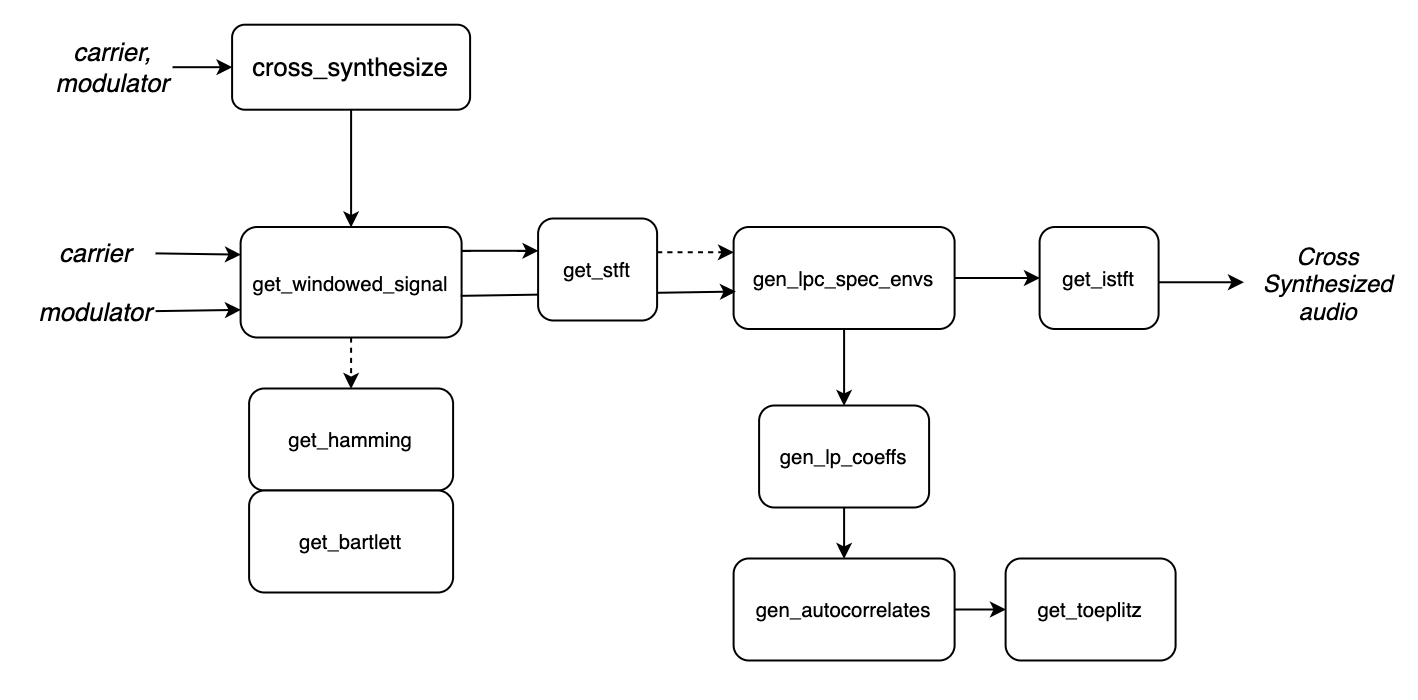

We pass the carrier and modulator audio files to <b>cross_synthesize</b> along with a specified number of linear coefficients, window size, hop size, window function, and booleans for flattening the carrier spectrum and showing spectrograms at each step. <b>cross_synthesize</b> calls the subsequent functions. A conceptual diagram of the flow of  <b>cross_synthesize</b> is as follows:

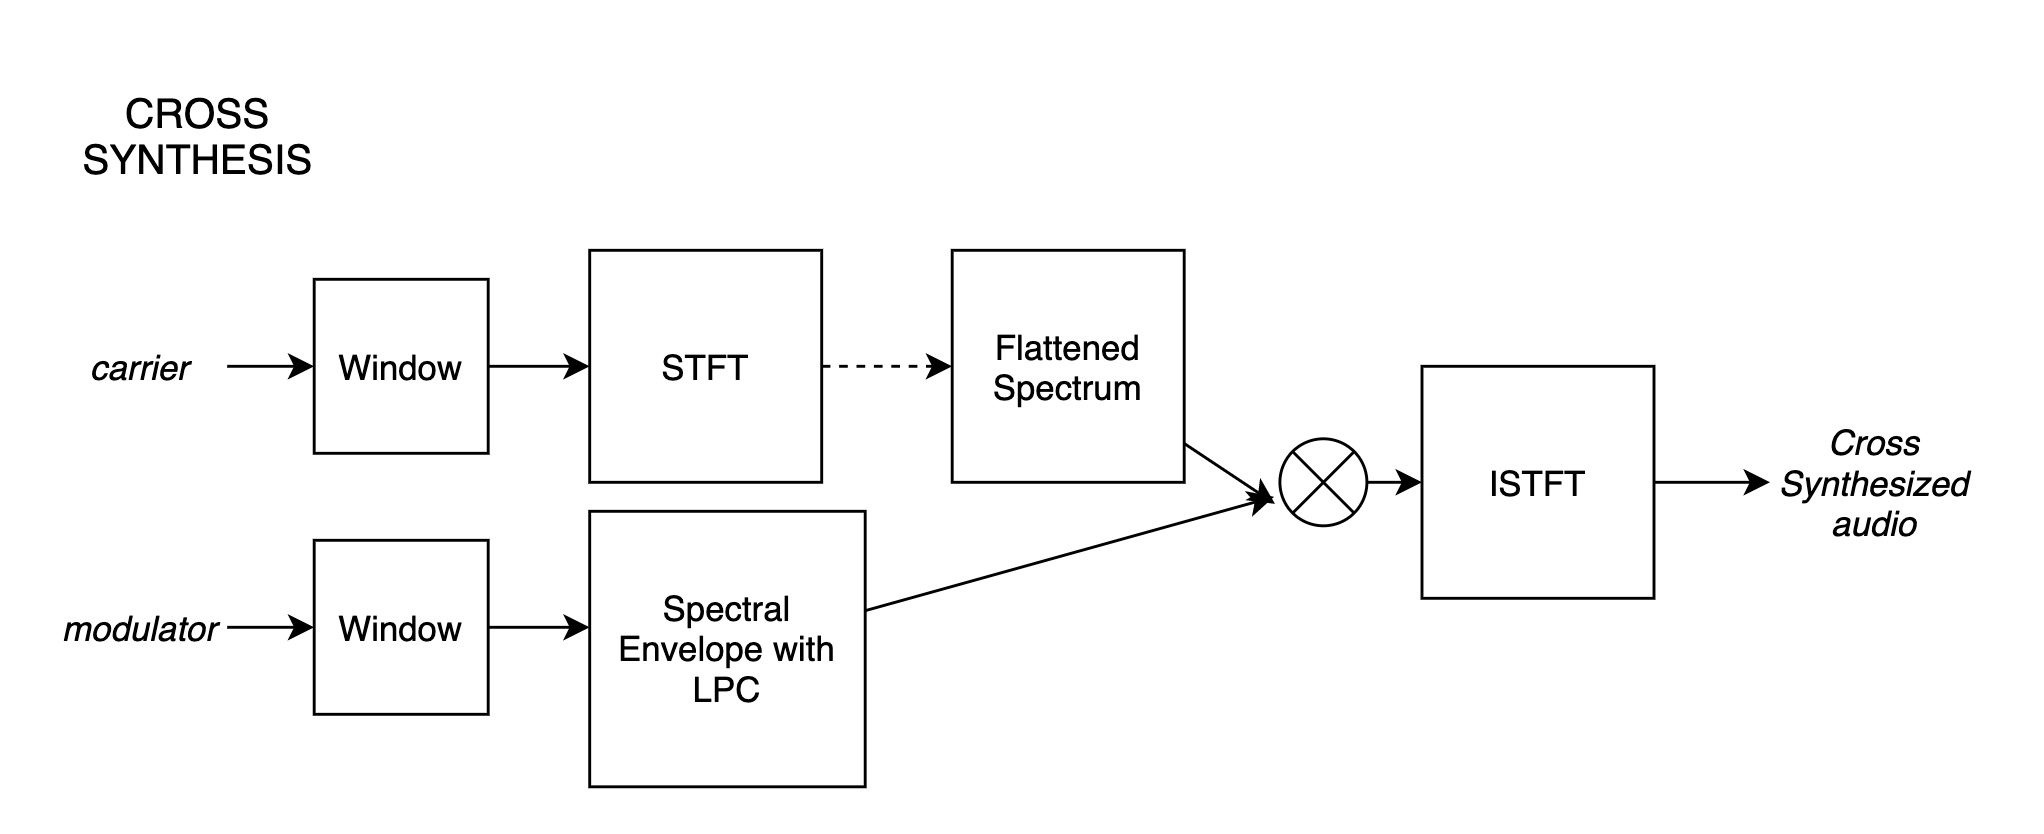

We extract the spectral envelope of the windowed modulator signal and  multiply this by the (optionally flattened) spectrum of the carrier signal. This will impress the envelope of the modulator to the spectrum of the carrier. We take the inverse STFT of this modified spectrum resulting in the cross synthesized audio. 

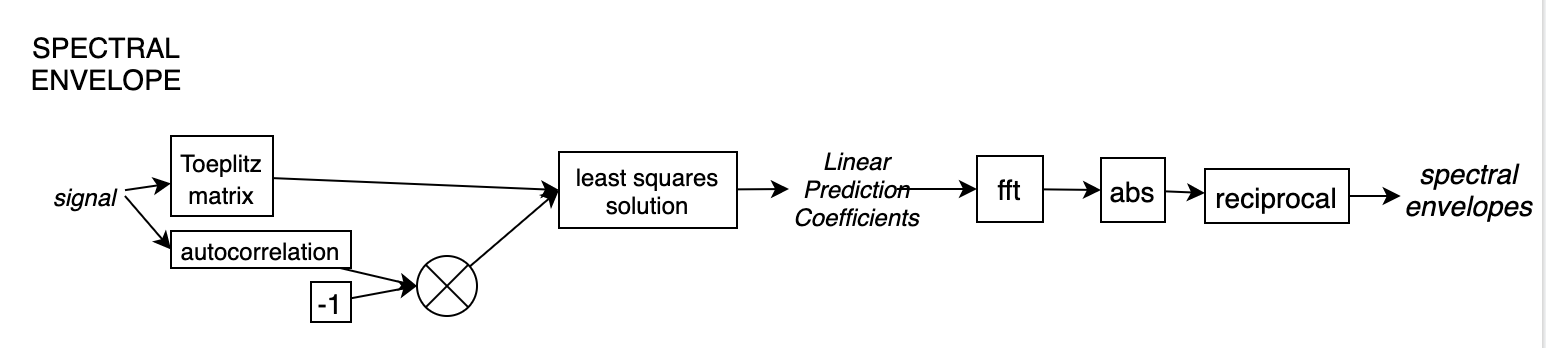

To extract the spectral envelope of the signal we take the M x M Toeplitz matrix of the signal for M linear coefficients and the autocorrelation vector $r_x$. We solve the system of linear equations produced by $a = R/r$ where a is the vector of linear coefficients, R is the Toeplitz matrix and r is the autocorrelation vector. We use <b>np.linalg.lstsq</b> to solve for $a$. 

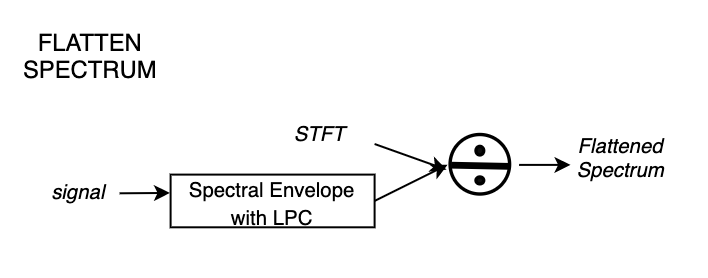

Optionally, we can flatten the spectrum of the carrier, which is done dividing the carrier spectrum by the carrier's spectral envelope.

# Results
Our process successfully performs cross synthesis on two audio signals.
For best cross synthesis, we use M=6 for the number of linear coefficients for generating spectral envelopes. 

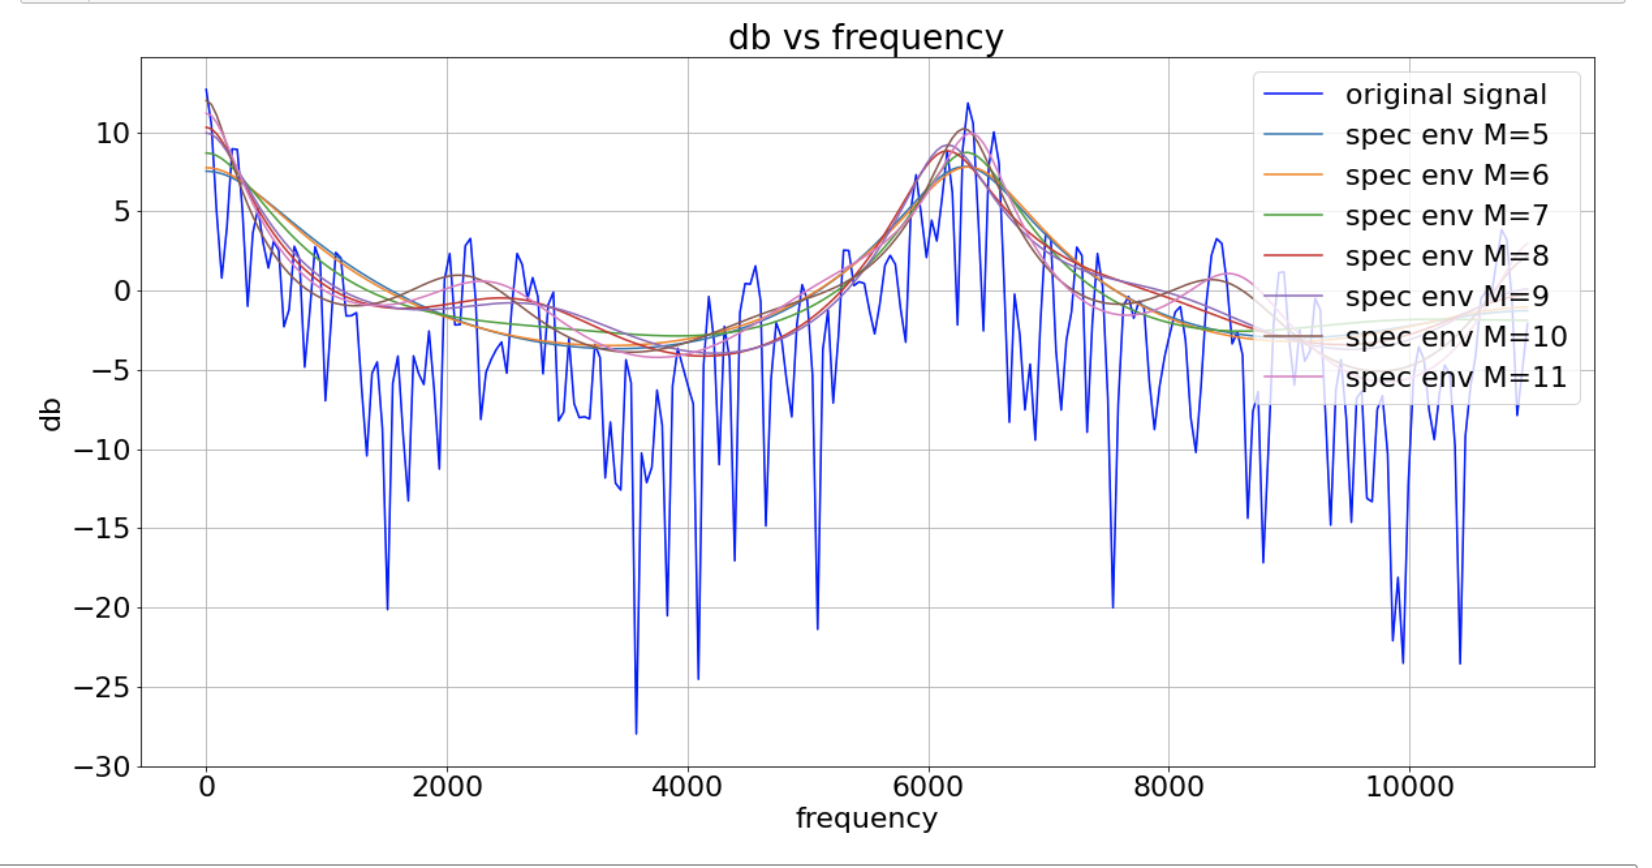

### Spectral Flattening

We found that flattening the carrier spectrum by its spectral envelope improves the quality of our cross-synthesized audio. Below shows the effect of flattening the carrier spectrum. The two spectrograms display the cross synthesized spectrum of an organ (carrier) sound and a male voice (modulator). The top graph is without flattening the carrier and the bottom graph shows with flattening. 

**Carrier without Flattening**
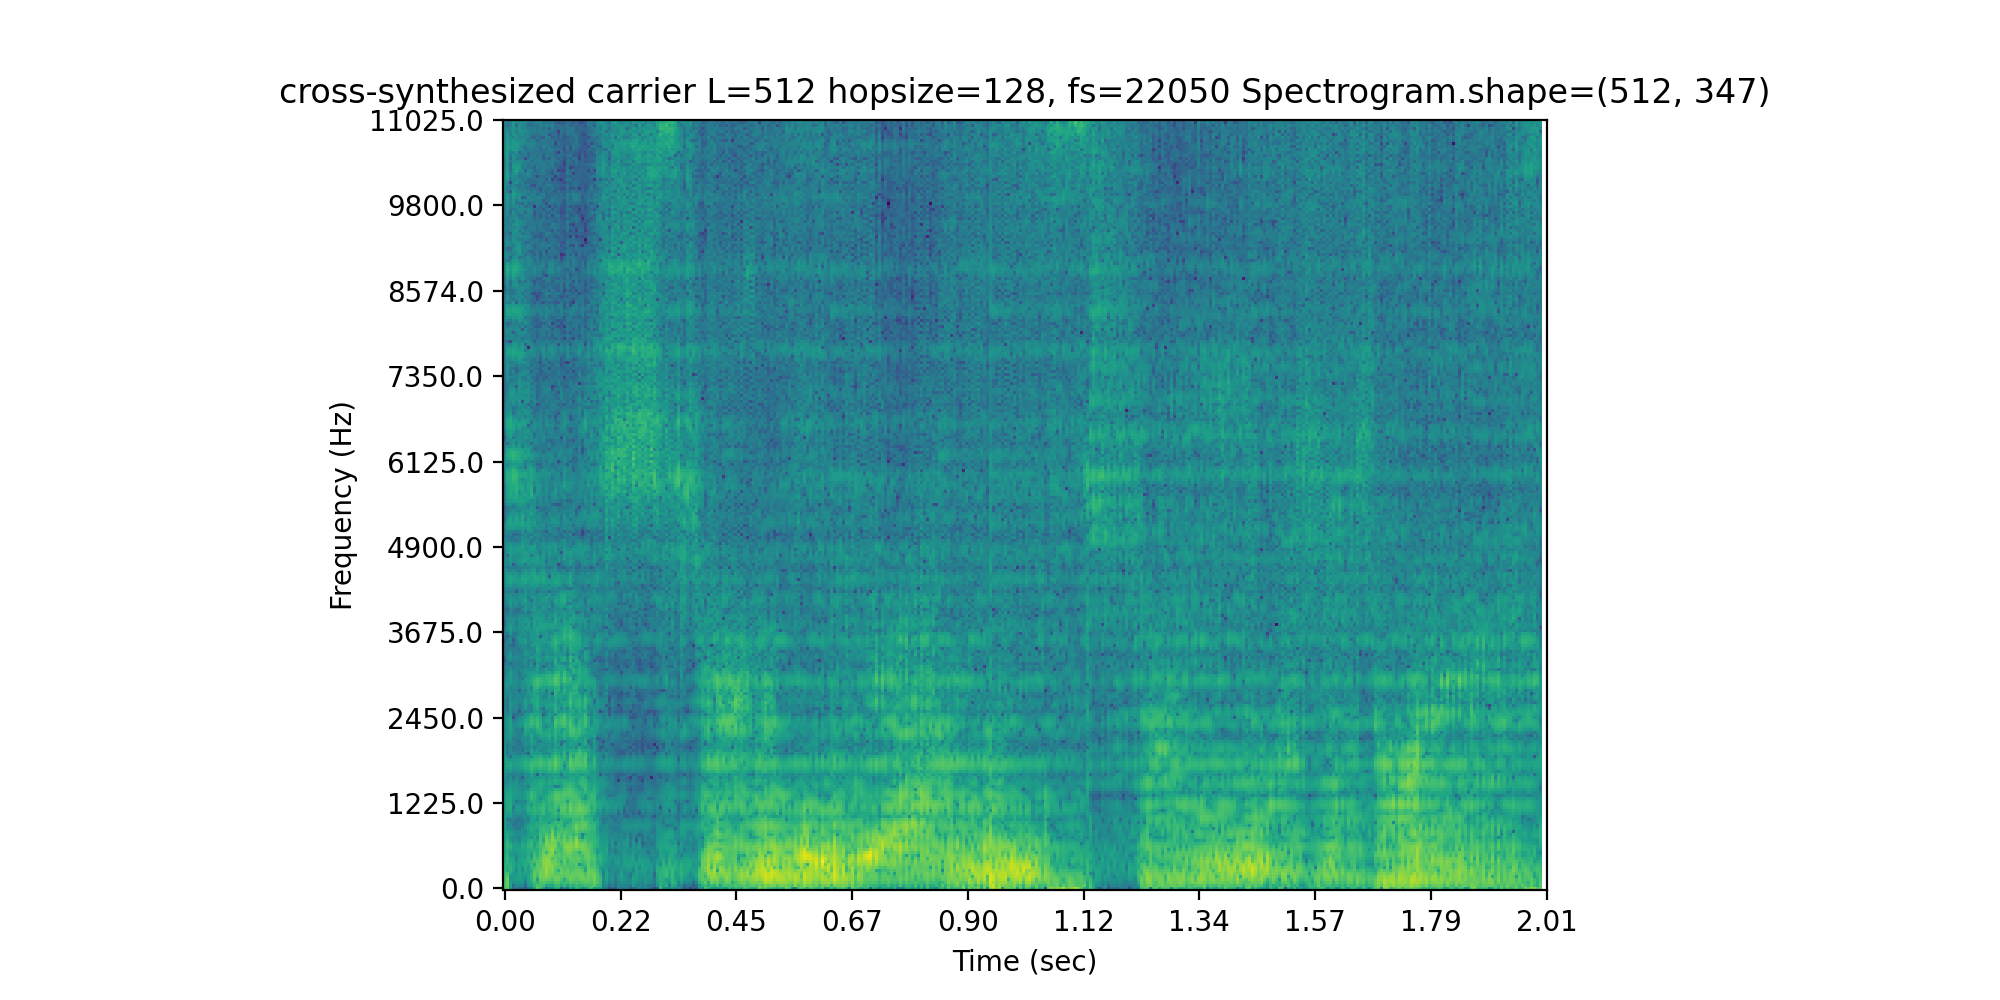

**Carrier with Flattening**
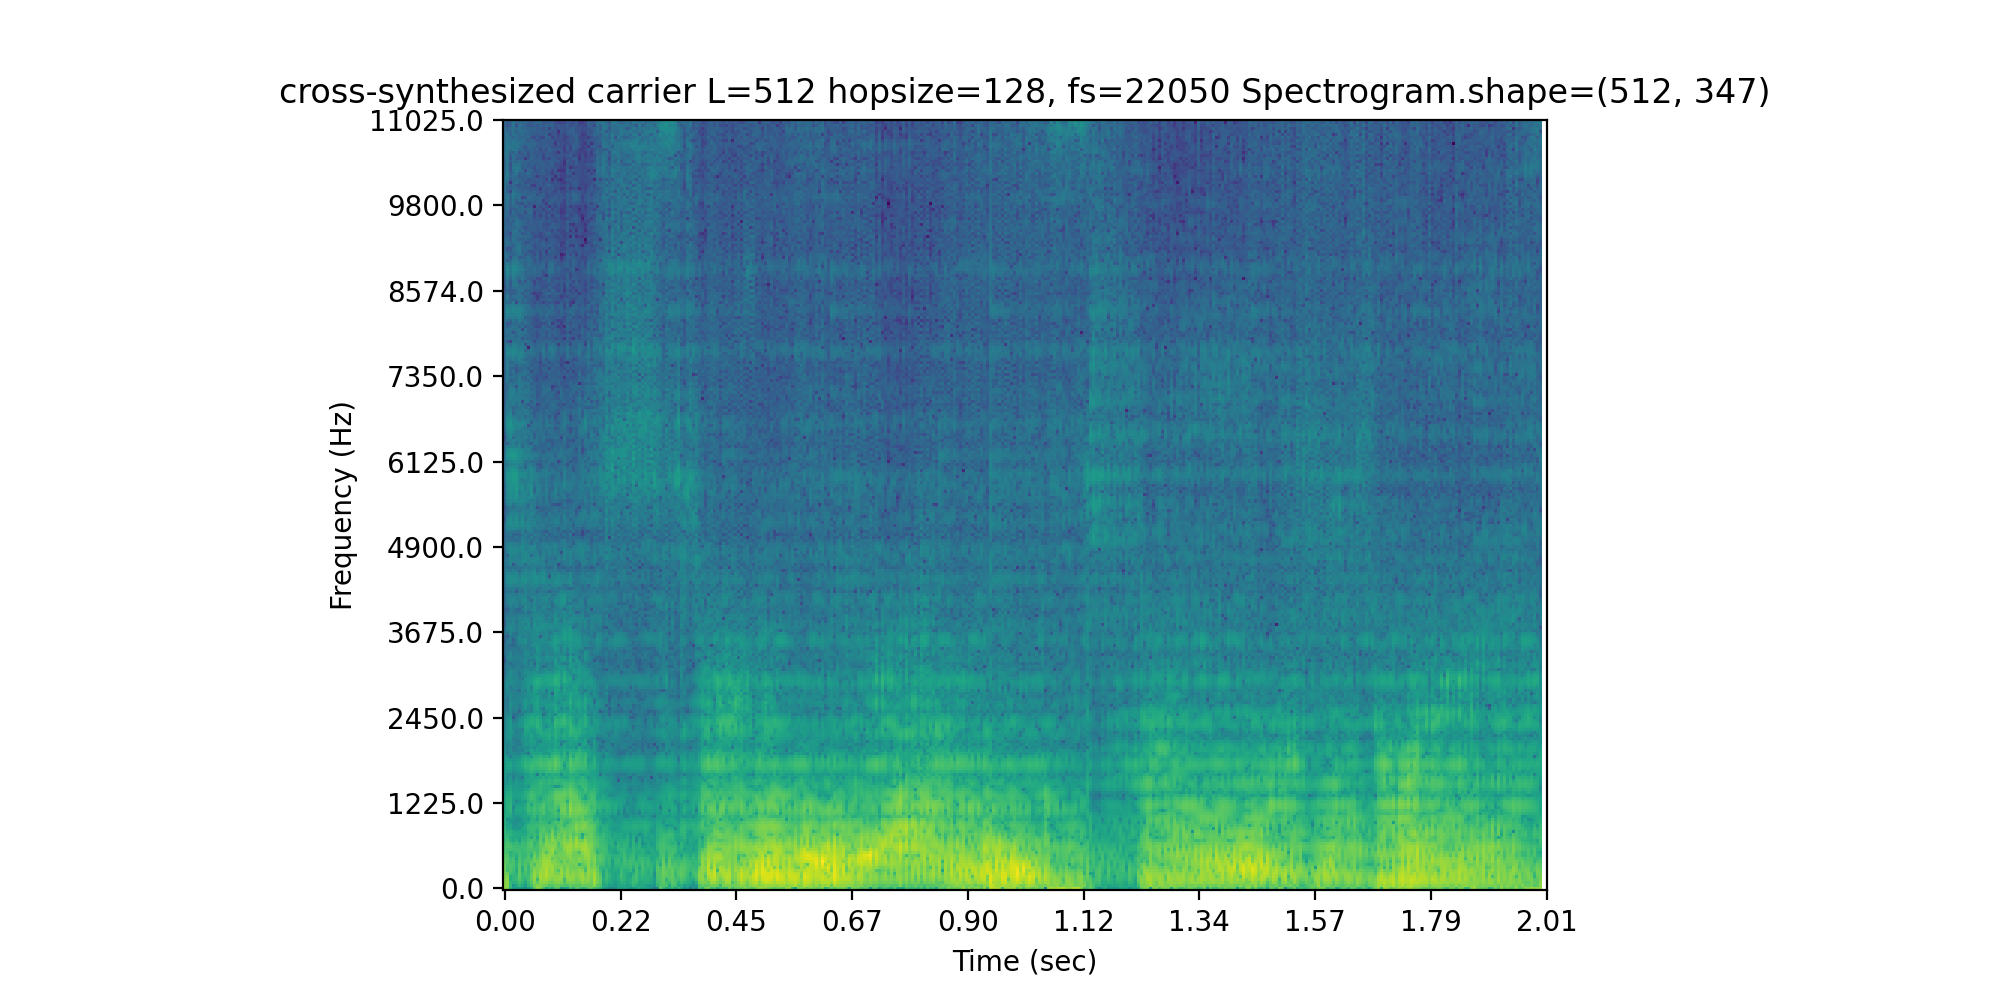

### Testing Various Window Functions

Using a window function on our signals increases the quality of our cross-synthesized audio. Below shows the spectrum of our cross-synthesized signal with no window, a Bartlett window, and a Hanning window with a flattened carrier. We noticed through trying various modulator/carrier combinations that the Bartlett window sounds best, and rectangular window the worst.

We noticed that cross-synthesizing with a rectangular window resulted in a lot of clips / noise artifacts. We suspect this is because the rectangular window has such a shallow rolloff, resulting in the generation of many artificial frequency peaks during cross-synthesis.

**No Window**
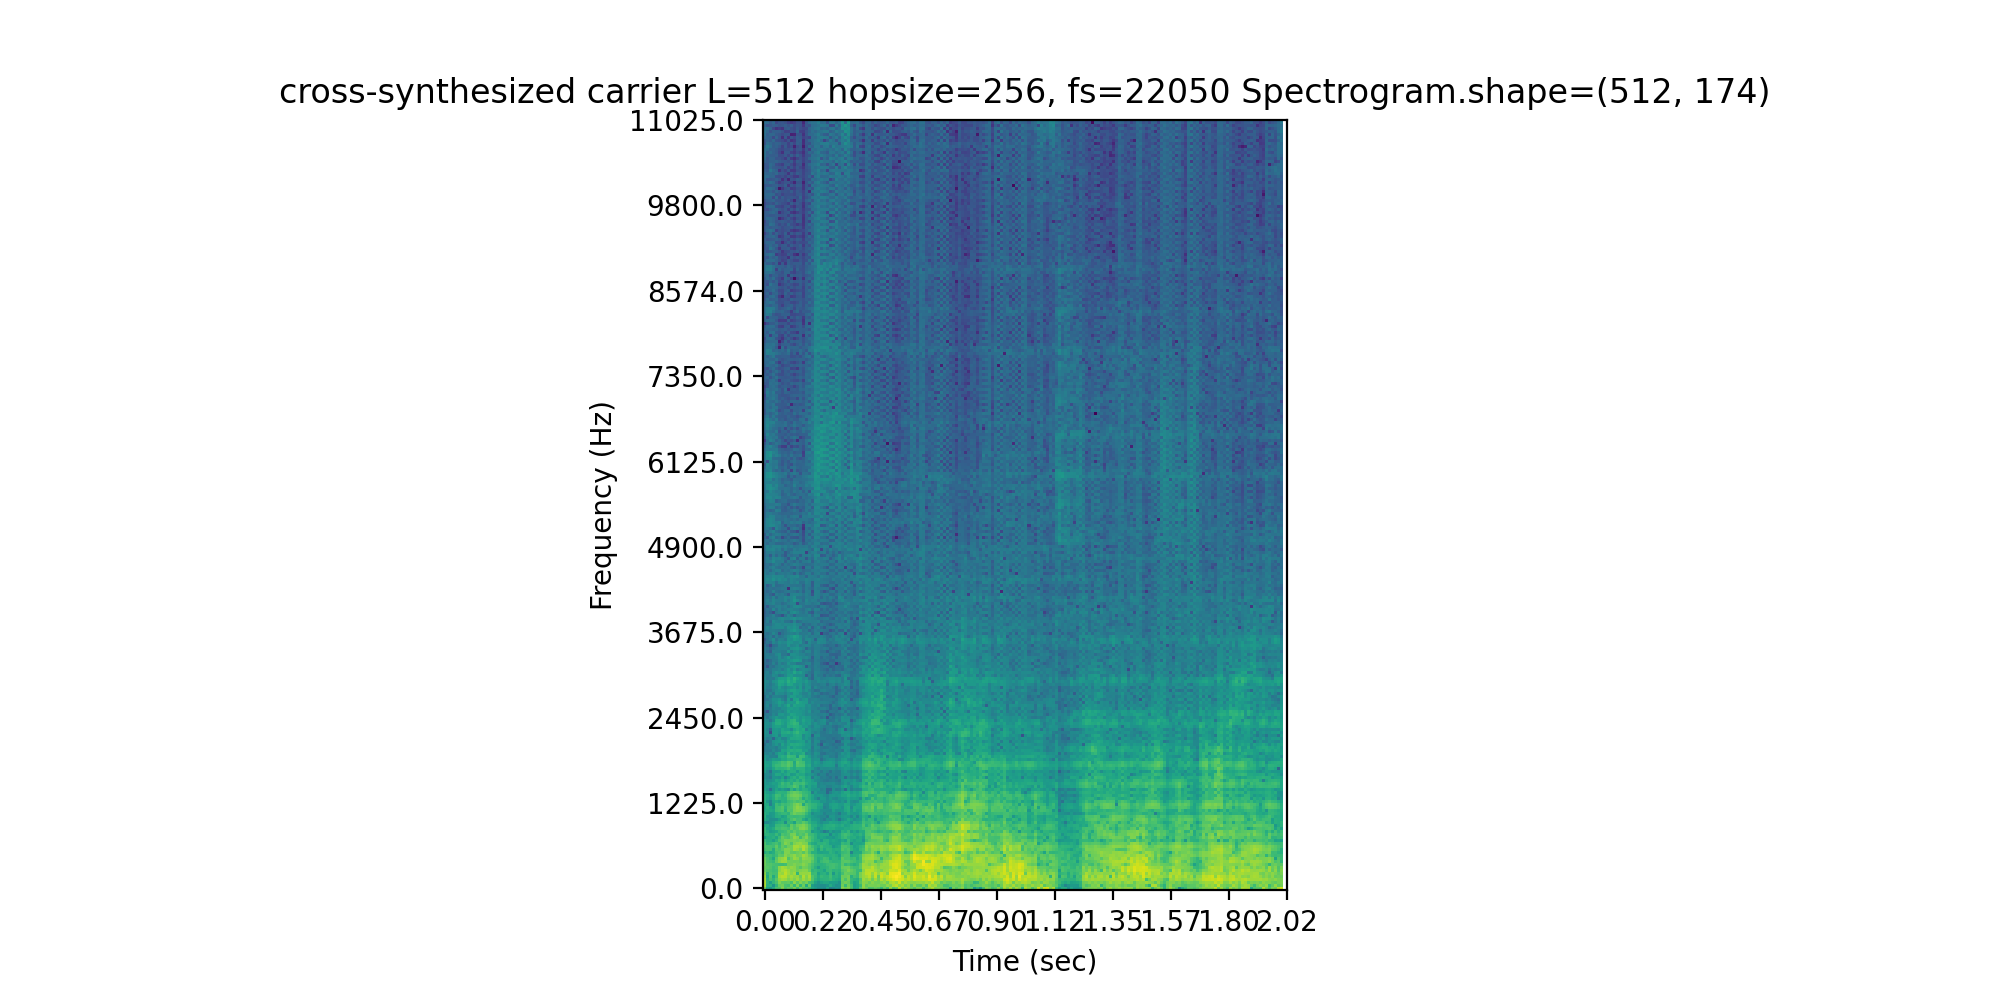

**Bartlett Window**
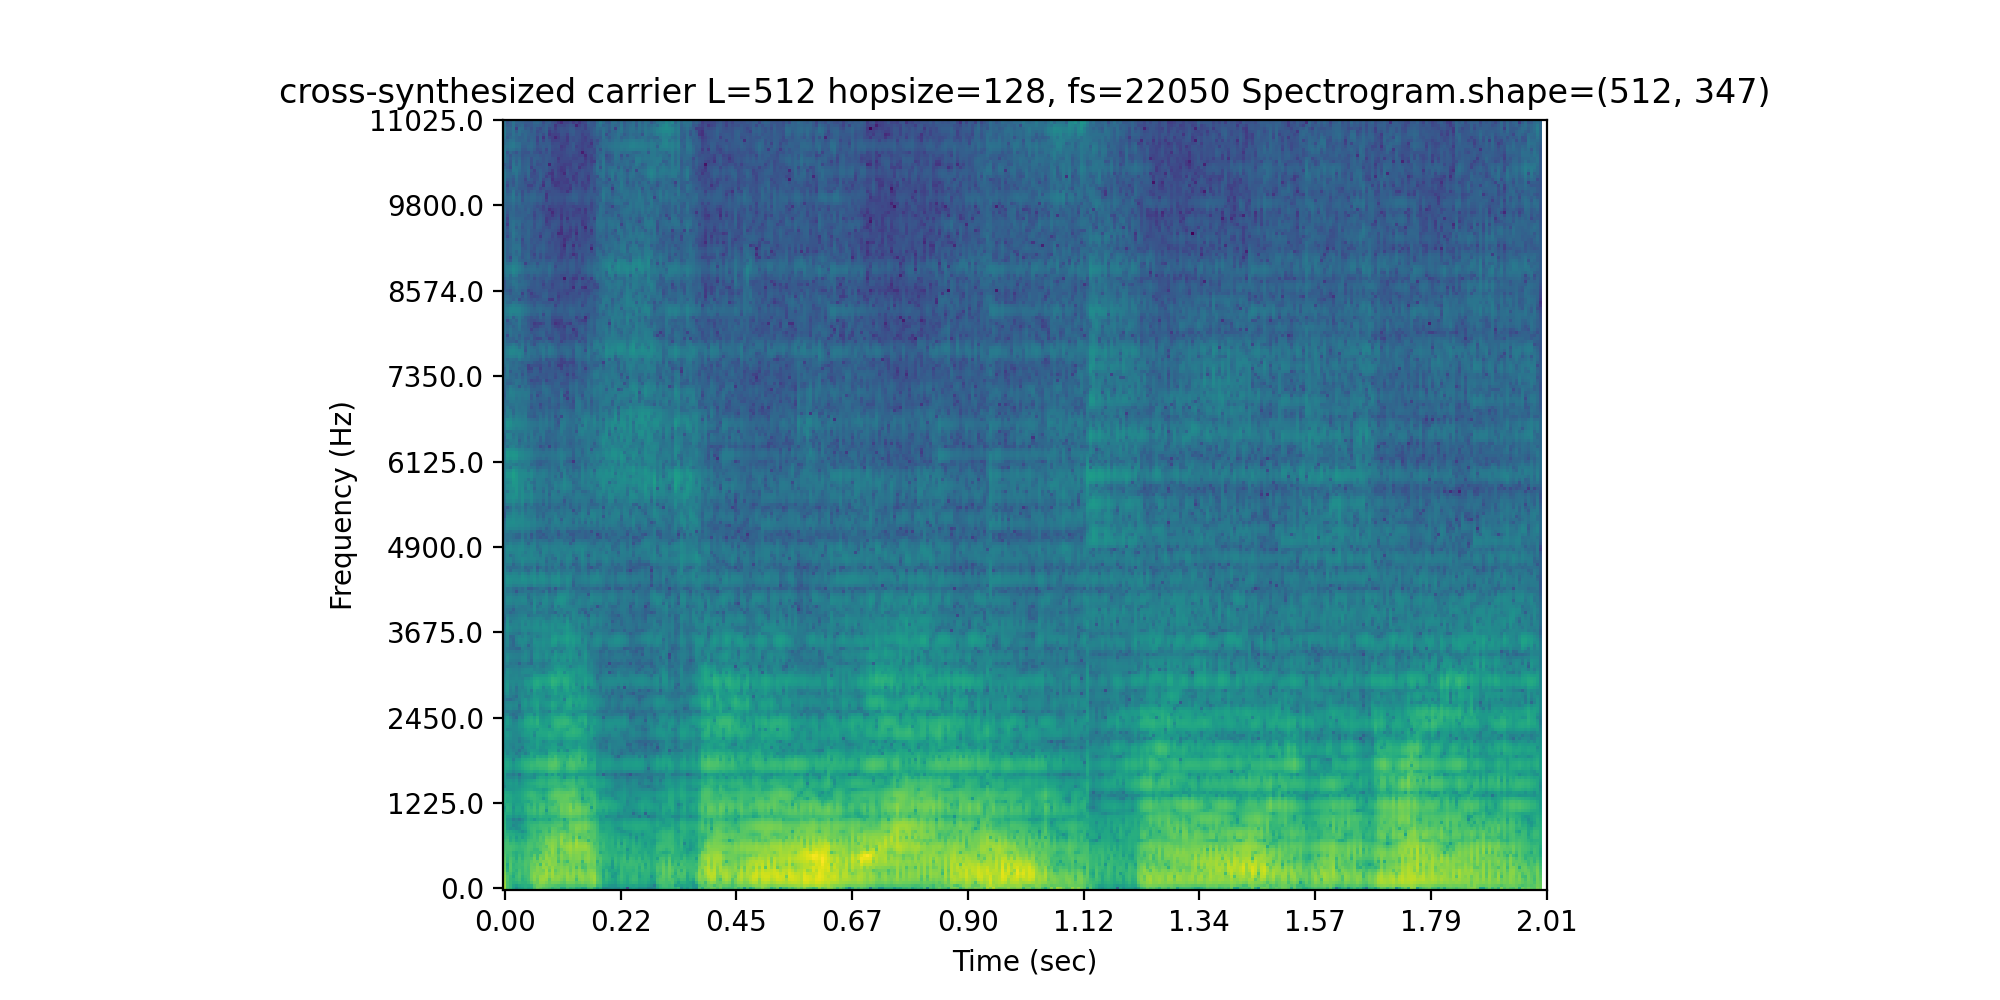

**Hanning Window**
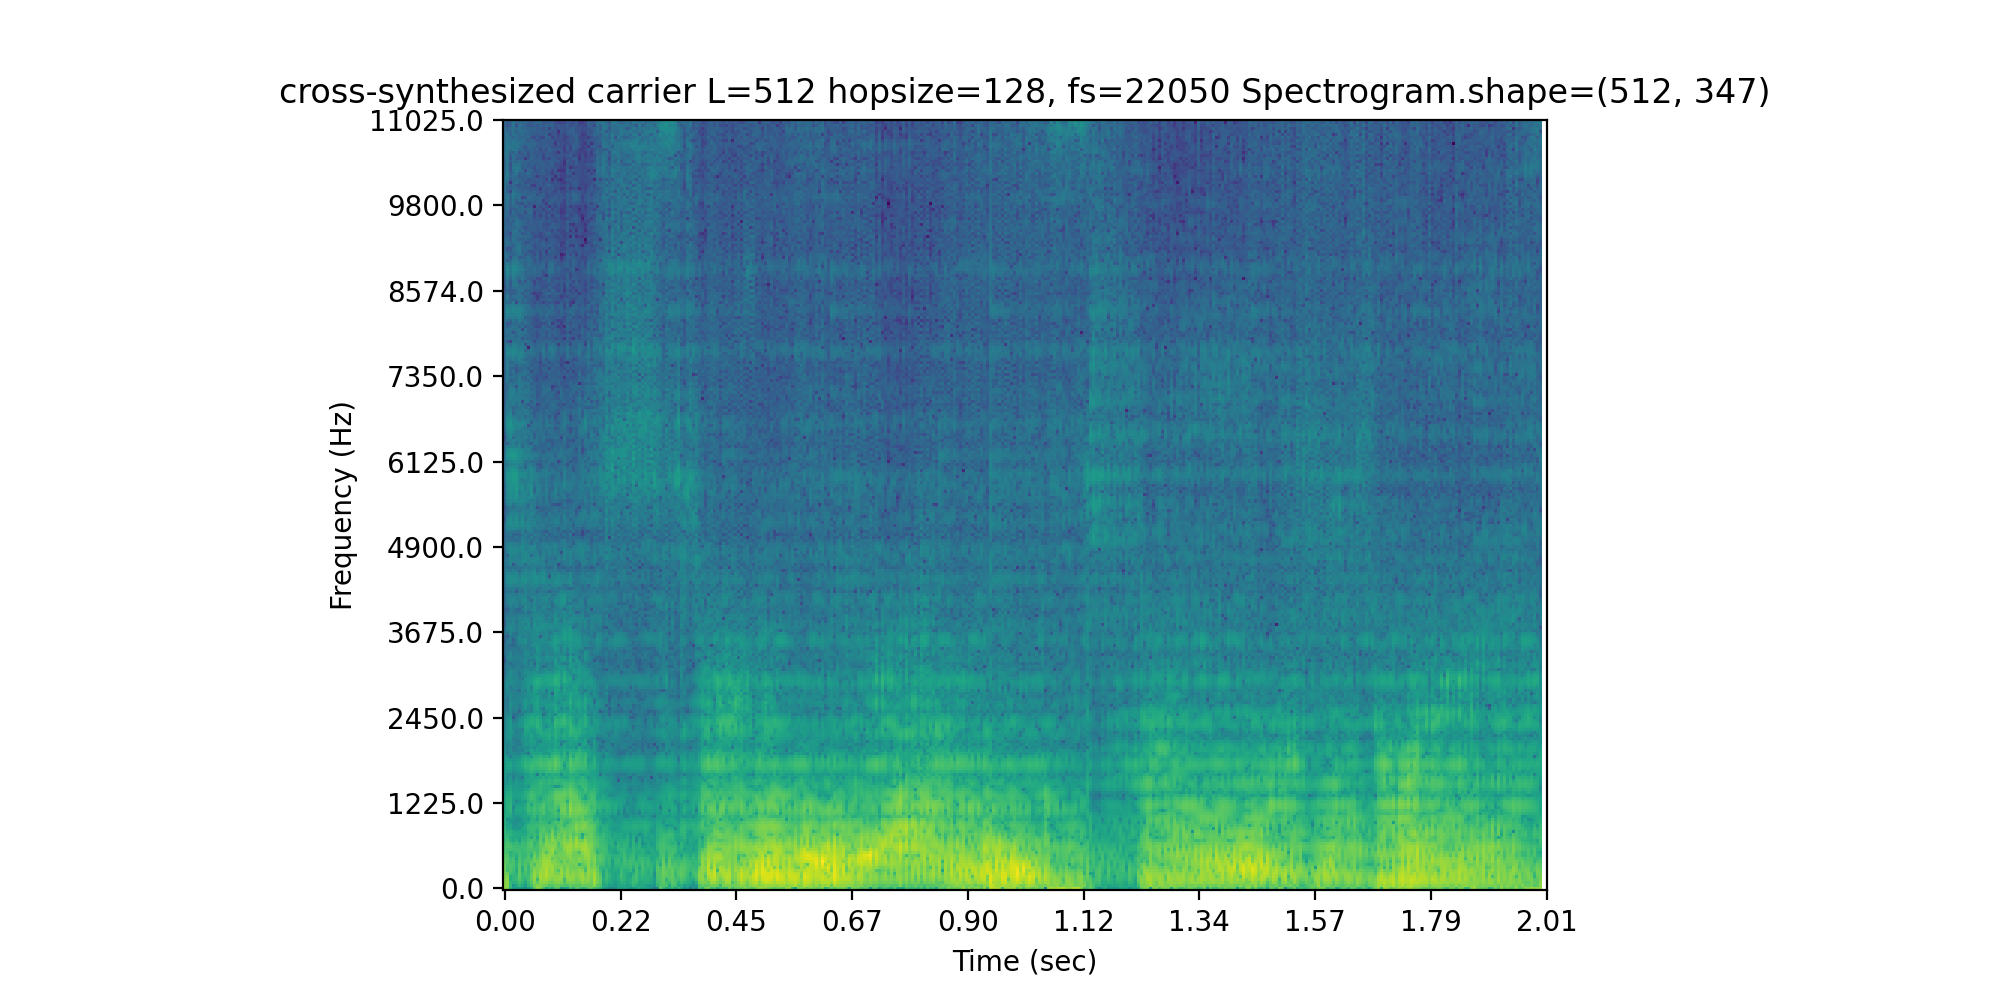

# Conclusions and Future Work

We are enthused by the application that we have developed together. At this stage, it works exactly as it should: we are able to input a carrier and modulating signal, and we recieve an cross-synthesis as output. Of course, with a project as open-ended as this, it is perhaps impossible ever to be truly finished. While we are more than happy with the end product at which we have arrived, in fiddling around with it, we already know what directions we would take our cross-synthesis app should we find the opportunity and motivation to improve upon it in the future:

### Expanding Accessibility

While our application is functional, we will be the first to admit that it is not the easiest to use. At its current state, our application requires one to download its code and content directly, and then navigate to the app's executable within the Terminal. From here, the interface is not exactly the most intuitive--even we, the developers, still get confused by it from time to time.

Our original vision for this application was to make it as accessible as possible such that we, or anyone else, would be able to call upon it easily when there is a need for some cross-synthesized audio. We didn't get around to developing a proper GUI or our stretch goal of a web-based application (in which no downloads are necessary) because ultimately, while these goals are legitimate, they live outside of the purview of this course and this assignment. Rest assured, we remain enthusiastic about bolstering our application's accessibility at a later date; only this way will we be able to prevent the inevitable headaches that will arise should we have to re-teach ourselves how to operate this program whenever we want to use it.

### Expanding Capabilities

In testing our program, we have become acutely aware of what our application isn't currently capable of doing, and some of these deficiencies are especially frustrating to have to work around. For one, we have noticed that our program is not capable of handling digital audio files that are above a certain bit depth. While it has no problem with 16-bit audio, 24-bit files do not enjoy the same status. In addition, any audio files that are compatible must still first be manually placed within either the "carriers" or "modulators" directories. Our eventual hope is that the the user will be able to direct the application to find the location of an audio file on their computer.

At the moment, our application is hard-coded to limit the maximum duration of output at five seconds. We made this choice so that the program would not take an eternity to run, but in an ideal world the user should be able to set the limit for themself. We will continue to find ways in which we can optimize the workflow so as to reduce the runtime and encourage longer syntheses.

### More Creative Control?

Our application at the moment accomplishes exactly one thing: input carrier and modulator audio files, output a cross-synthesis of those files. Admittedly, there is little room for a musician to get creative with the application in its current state, but that may not have to always be the case. At the University of California San Diego, fellow computer musicians Chris Donohue, Tom Erbe and Miller Puckette wrote a paper entitled "Extended Convolution Techniques for Cross-Synthesis" which laments this very lack of creative maneuverability and proposes a couple of techniques that, if implemented, would give more options to musicians. 

One technique is "brightness control," which posits that a geometric mean should be implemented when combining the magnitude spectra of the two signals such that the effects of constructive and destructive interference are mitigated, presumably resulting in a more balanced, brighter sound. Another technique is "source emphasis," in which one can skew the cross-synthesis' emphasis toward one sound or the other by separating the input signals into magnitude and phase spectra by fast convolution, after which magnitude can be adjusted. These are only a few ideas that if implemented would make our application a more versatile tool and less of a one-trick pony.

## References

**Relevant CCRMA online literature that got us started and kept us going:**

https://ccrma.stanford.edu/~jos/sasp/Spectrum_Analysis_Noise.html

https://ccrma.stanford.edu/~jos/sasp/Cross_Synthesis.html

https://ccrma.stanford.edu/~jos/filters/Z_Transform_Difference_Equations.html



**"Spectral Audio Processing using the STFT and Cross Synthesis":**

musicweb.ucsd.edu/~sdubnov/Mu172/Lectures/STFTXsynth.pdf

This is a link to the spec to an STFT/Cross Synthesis assignment put together by Shlomo Dubnov and Chris Warren for a computer music course at the University of California San Diego. It gave us some perspective of how to turn the concept of "cross-synthesis" into a tangible project.



**"Extended Convolution Techniques for Cross-Synthesis":**

quod.lib.umich.edu/cgi/p/pod/dod-idx/extended-convolution-techniques-for-cross-synthesis.pdf

A paper written by Chris Donahue, Tom Erbe, and Miller Puckette at the University of California San Diego detailing the capabilities and limitations of discrete convolution cross-synthesis, and introducing possible ways to extend and enhance the discrete convolution process by implementing new procedures for creative control.

## Special Thanks

There are several people who helped us put this whole thing together, chief among them professor Julius Smith, who offered us his time, experience and insight whenever we had questions about choosing which windows and filters to use, understanding key mathematical concepts, and debugging our issues as they came up. We could not have done it without you, Julius!

We also owe an incredible debt of gratitude to our 320A professor for this term, Marina Bosi, and our tireless TA Vidya Rangasayee. Thank you both for providing us with guidance, structure and creative liberty throughout the term, as well as positive encouragement throughout the final project process.